In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit

file_path = "octet_truss_temp_dT_01_005.txt" #name of comsol file
data = pd.read_csv(file_path, sep=",", skiprows=9,
                   names=["X", "Y", "Z", "T200", "T400", "T800", "T1000", "T1200"])




===== Processing T200 =====
Best Model for T200: Polynomial (deg=9)


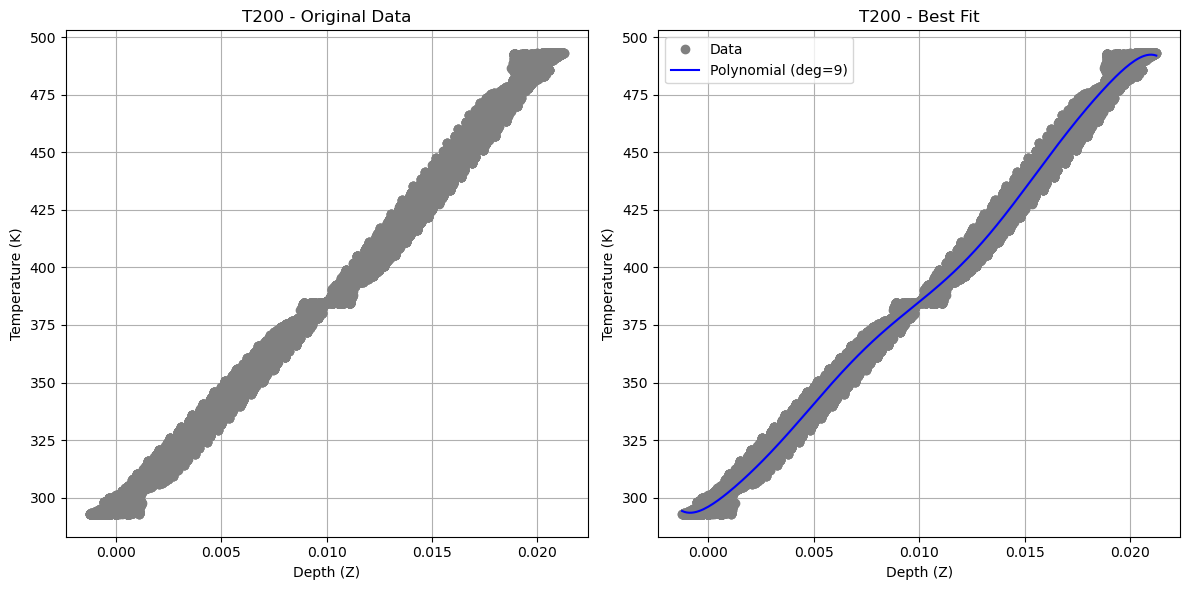


===== Processing T400 =====
Best Model for T400: Polynomial (deg=9)


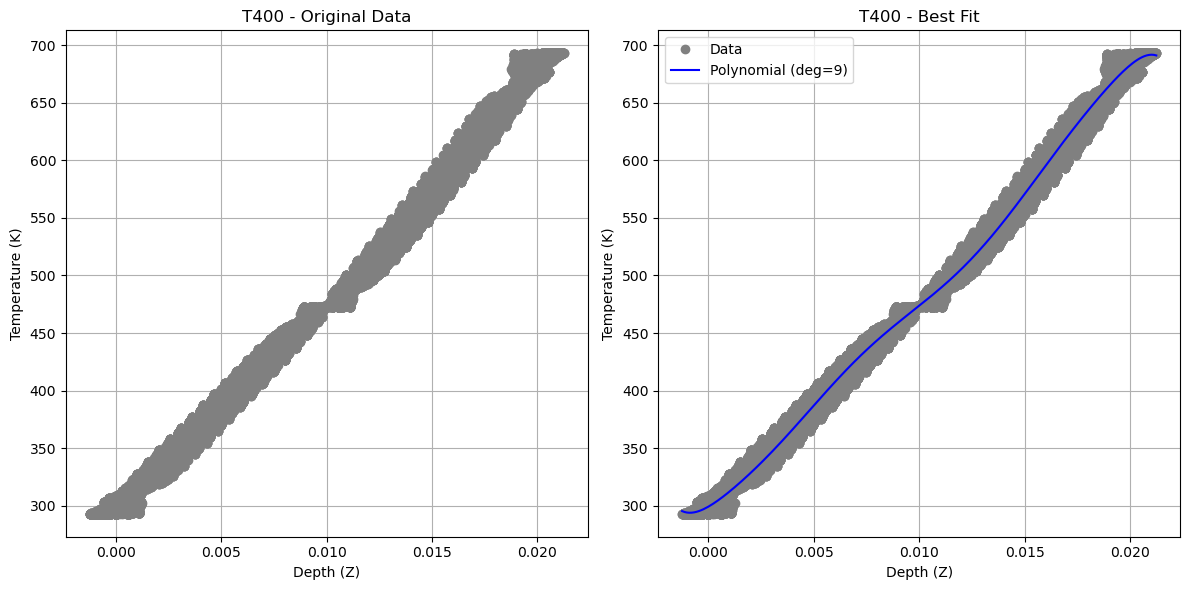


===== Processing T800 =====
Best Model for T800: Polynomial (deg=9)


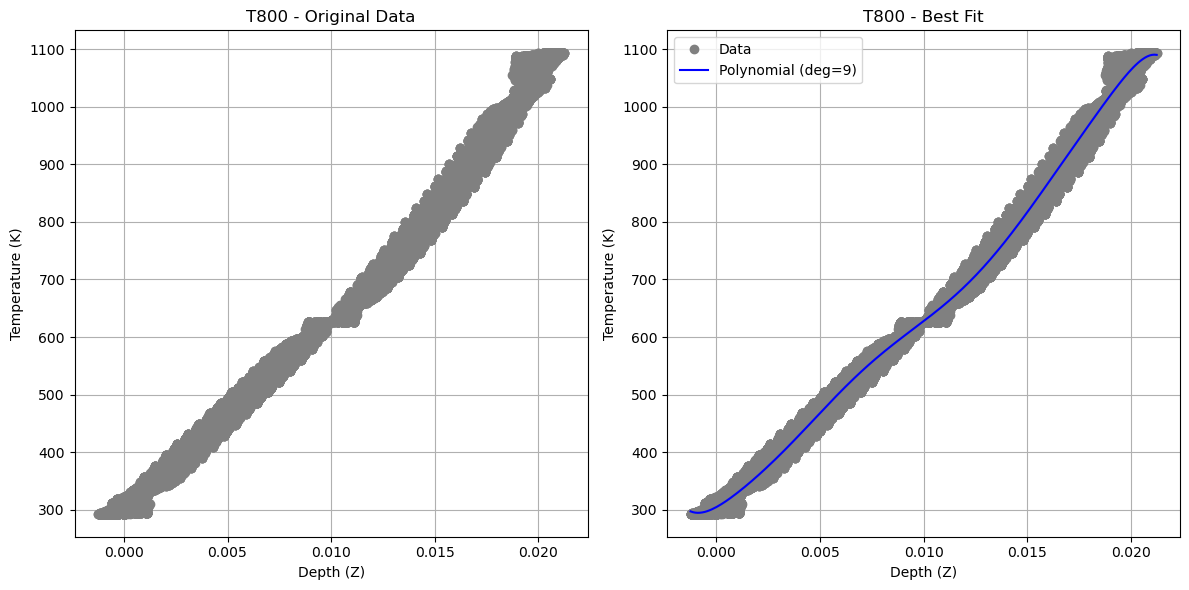


===== Processing T1000 =====
Best Model for T1000: Polynomial (deg=9)


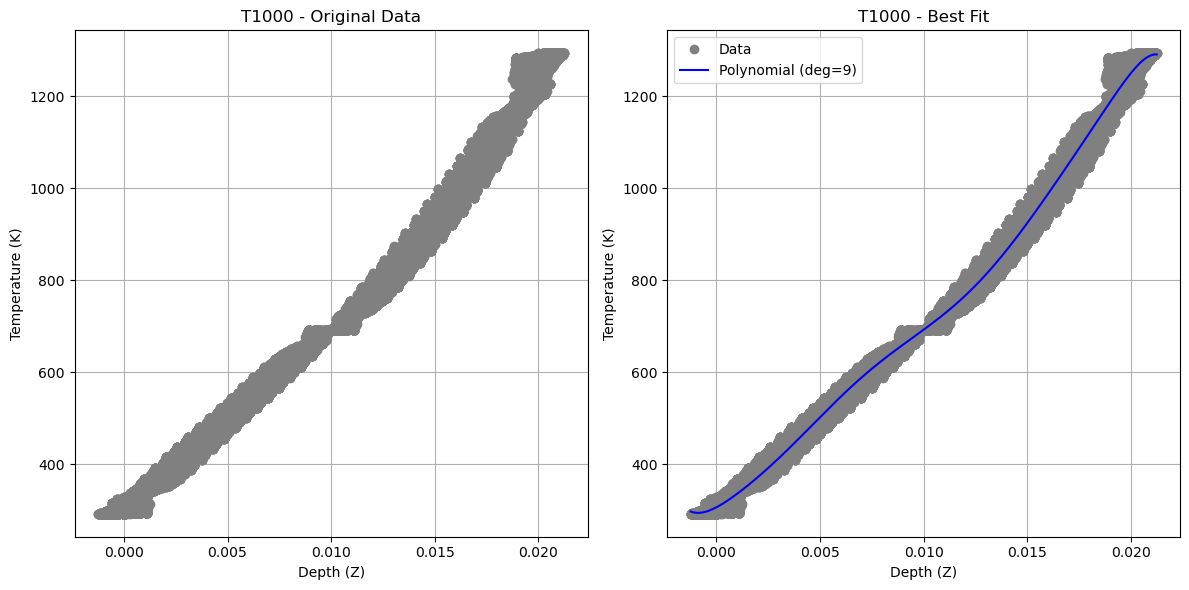


===== Processing T1200 =====
Best Model for T1200: Polynomial (deg=9)


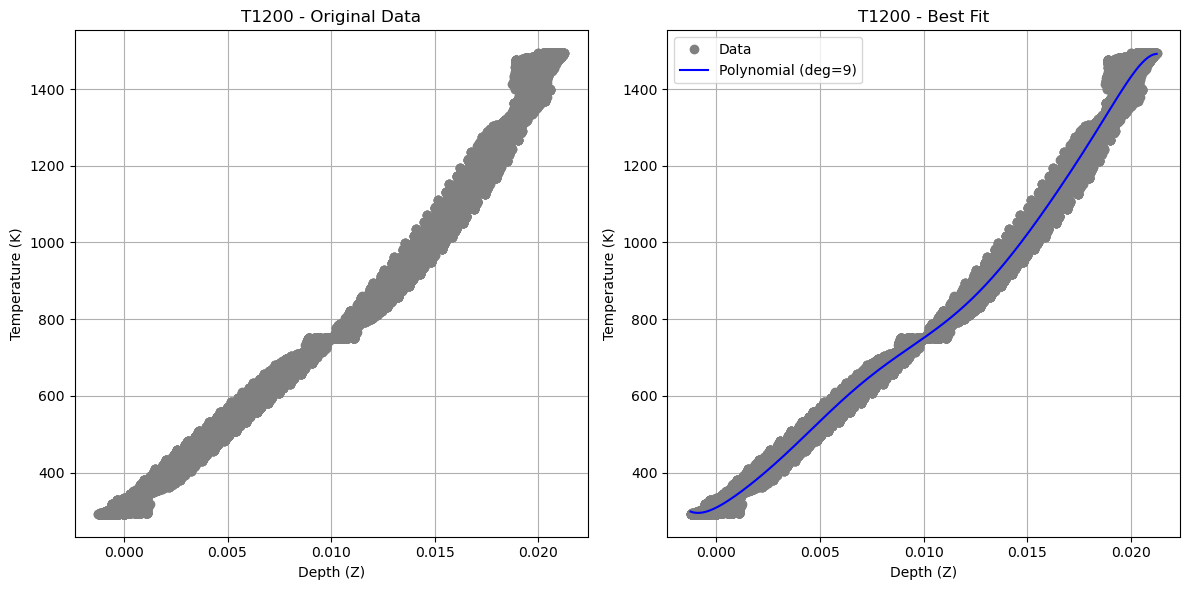

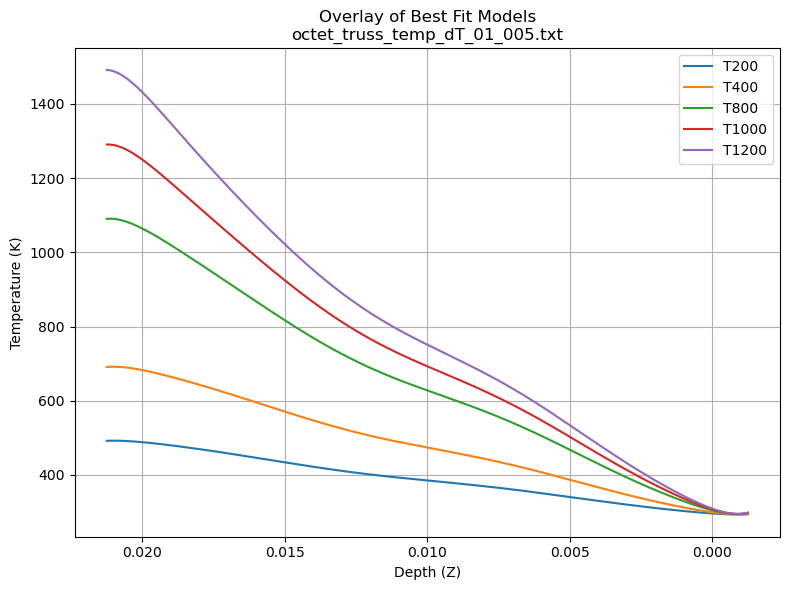

In [2]:

# --- Fit functions ---
def log_func(T, a, b):
    return a * np.log(T) + b   # T = x-axis (temperature), returns depth

# --- Loop over ΔT cases ---
temp_cols = ["T200", "T400", "T800", "T1000", "T1200"]

overlay_curves = []  # store fits for overlay plot

for col in temp_cols:
    print(f"\n===== Processing {col} =====")
    
    subset = data[["Z", col]].dropna().rename(columns={col: "Temperature"})
    avg_temp_per_depth = subset.groupby("Z")["Temperature"].mean().reset_index()
    avg_temp_per_depth = avg_temp_per_depth.sort_values(by="Z")

    T = avg_temp_per_depth["Temperature"].values  # y-axis
    Z = avg_temp_per_depth["Z"].values            # x-axis
    T_log = np.where(T <= 0, 1e-6, T)             # avoid log(0)

    # --- Logarithmic Fit ---
    try:
        log_params, _ = curve_fit(log_func, T_log, Z, p0=(1, np.mean(Z)))
        Z_logfit = log_func(T_log, *log_params)
        log_r2 = r2_score(Z, Z_logfit)
    except RuntimeError:
        log_r2 = -np.inf

    # --- Polynomial Fits ---
    best_poly_r2 = -np.inf
    best_poly_deg = None
    best_poly_model = None

    for deg in range(1, 10):
        coeffs = np.polyfit(Z, T, deg=deg)  # <-- flip order: Z = x, T = y
        poly_func = np.poly1d(coeffs)
        T_pred = poly_func(Z)
        r2 = r2_score(T, T_pred)
        if r2 > best_poly_r2:
            best_poly_r2 = r2
            best_poly_deg = deg
            best_poly_model = poly_func

    # --- Pick best model ---
    if best_poly_r2 >= log_r2:
        best_model_name = f"Polynomial (deg={best_poly_deg})"
        best_model_func = best_poly_model
    else:
        best_model_name = "Logarithmic"
        best_model_func = lambda x: log_func(np.where(x <= 0, 1e-6, x), *log_params)

    print(f"Best Model for {col}: {best_model_name}")

    # --- Smooth curve for plotting ---
    Z_smooth = np.linspace(Z.min(), Z.max(), 200)
    T_fit = best_model_func(Z_smooth)

    # Save for overlay plot
    overlay_curves.append((col, Z_smooth, T_fit))

    # --- Plotting individual case ---
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

    # Original Data
    axs[0].plot(Z, T, "o", color="gray")
    axs[0].invert_xaxis()  # max Z on left, min Z on right
    axs[0].set_xlabel("Depth (Z)")
    axs[0].set_ylabel("Temperature (K)")
    axs[0].set_title(f"{col} - Original Data")
    axs[0].grid(True)

    # Best Fit
    axs[1].plot(Z, T, "o", label="Data", color="gray")
    axs[1].plot(Z_smooth, T_fit, "-", label=best_model_name, color="blue")
    axs[1].invert_xaxis()  # max Z on left, min Z on right
    axs[1].set_xlabel("Depth (Z)")
    axs[1].set_ylabel("Temperature (K)")
    axs[1].set_title(f"{col} - Best Fit")
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


# --- Overlay Plot for All Cases (Z on x-axis, Temp on y-axis) ---
plt.figure(figsize=(8, 6))
for col, Z_smooth, T_fit in overlay_curves:
    plt.plot(Z_smooth, T_fit, label=col)

plt.gca().invert_xaxis()  # max Z on left, min Z on right
plt.xlabel("Depth (Z)")
plt.ylabel("Temperature (K)")
plt.title(f"Overlay of Best Fit Models\n{file_path}")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Uncomment to save as PNG
# plt.savefig("overlay_best_fit.png", dpi=300)

plt.show()